# 项目简介
掌握使用nc文件绘图时出现的地图白边问题

## 本教程是该项目中涉及的cartopy相关代码分享，basemap代码请移步隔壁教程


配套视频链接：
https://www.bilibili.com/video/BV1kd4y1Q7fE

## 省流总结：
经度白边出现的原因：经度在0度附近不连续（0, 2.5, 5…357.5）

（1）cartopy经度中心（0度）白边问题
解决方法：调整中心经度+设置xticklabels → 正确对应经度

（2）basemap经度边缘白边问题
解决方法：调整Basemap区域，裁剪多余的经度
（如果是纬度白边同理，裁剪掉多余的即可）

（3）0度附近区域
解决方法参考：1）cartopy里面的add_cyclic_point函数可以直接把357.5 → 0看成连续的，来自@一阶魔方国家队成员 大佬；2）插值

*经测试，add_cyclic_point生成的新的lon里面有360，但xticks仍然没法取到360，可考虑取359.9并给它添加label为0度

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point

C:\ProgramData\Anaconda3\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
#导入文件
filename = r'C:\Users\LULU\Desktop\air\air.mon.ltm.1991-2020.nc'
f = xr.open_dataset(filename)

#查看文件信息
print(f)

<xarray.Dataset>
Dimensions:             (level: 17, lat: 73, lon: 144, time: 12, nbnds: 2)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) datetime64[ns] ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    Conventions:                    CF-1.0
    title:                          Monthly NCEP/DOE Reanalysis 2
    comments:                       Data is from \nNCEP/DOE AMIP-II Reanalysi...
    platform:                       Model
    source:                         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2...
    institution:         

C:\ProgramData\Anaconda3\lib\site-packages\xarray\backends\plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\coding\times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [3]:
#提取变量
lat = f['lat'].data
lon = f['lon'].data
air = f['air'].data[:,0,:,:]
air_mean = np.mean(air,axis=0)

#画图网格
X,Y = np.meshgrid(lon,lat)

## 测试1：经度白边问题
注意：使用xticks+xticklabels为经度设置label，可得到正确的经度显示

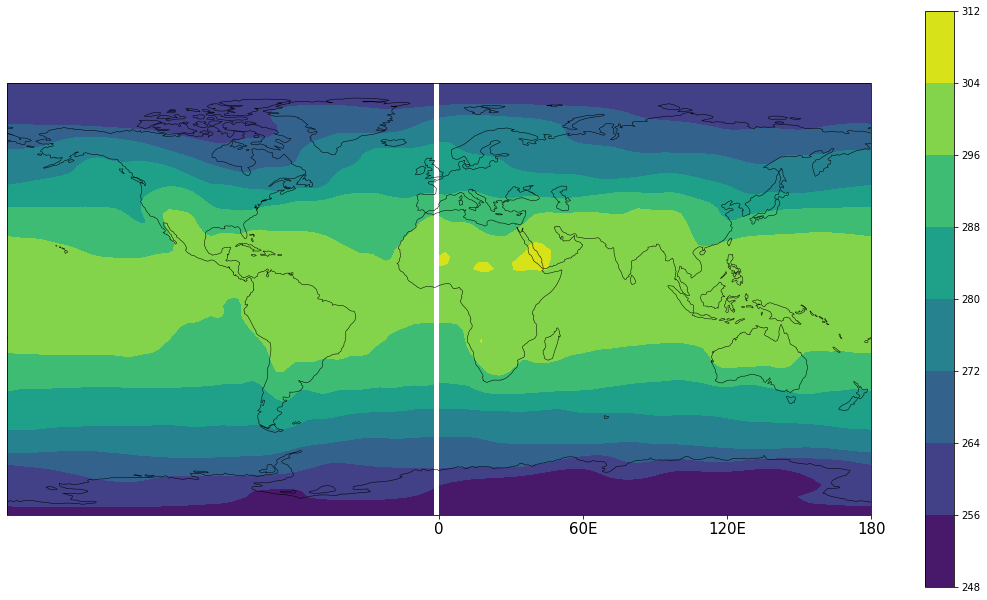

In [6]:
#画图
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_axes([0,0,1,1],projection = ccrs.PlateCarree())
ax1.set_xticks([0,60,120,180,240,300,360],crs=ccrs.PlateCarree())
ax1.set_xticklabels(['0','60E','120E','180','120W','60W','0'],fontsize=15)
ax1.add_feature(cf.COASTLINE,lw=0.5,zorder=2)  #绘制海岸线
con1 = ax1.contourf(X,Y,air_mean,transform=ccrs.PlateCarree())
fig.colorbar(con1)

## 测试2：调整中心经度central_longitude=180，白边消失

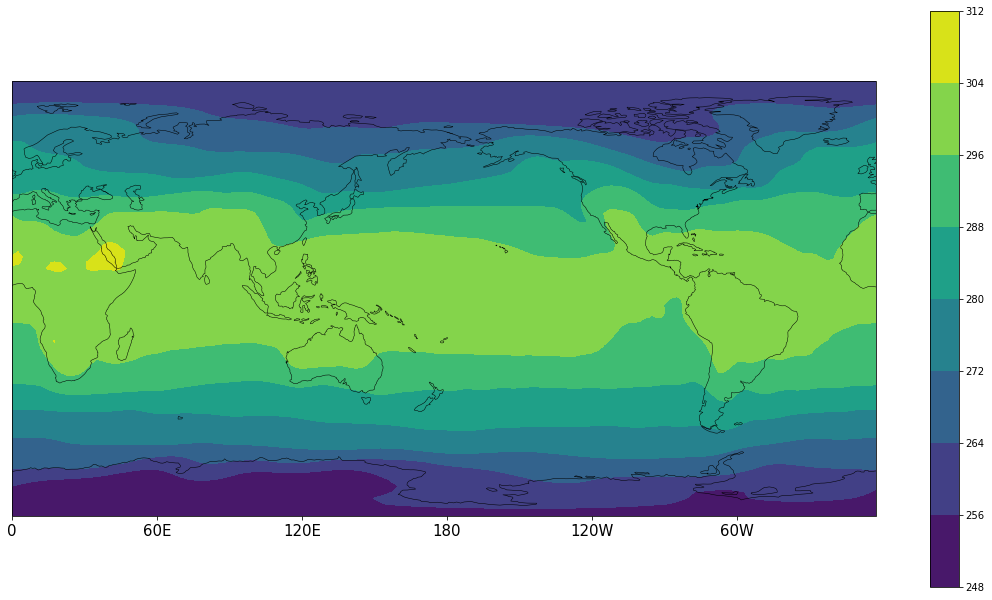

In [5]:
#画图
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_axes([0,0,1,1],projection = ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cf.COASTLINE,lw=0.5,zorder=2)
ax1.set_xticks([0,60,120,180,240,300,360],crs=ccrs.PlateCarree())
ax1.set_xticklabels(['0','60E','120E','180','120W','60W','0'],fontsize=15)
con1 = ax1.contourf(X,Y,air_mean,transform=ccrs.PlateCarree())
fig.colorbar(con1)

# 测试3：xticks取357.5（经度的最大值），并将其label（xticklabels）设置为0
（防止看右下角没有刻度不顺眼）

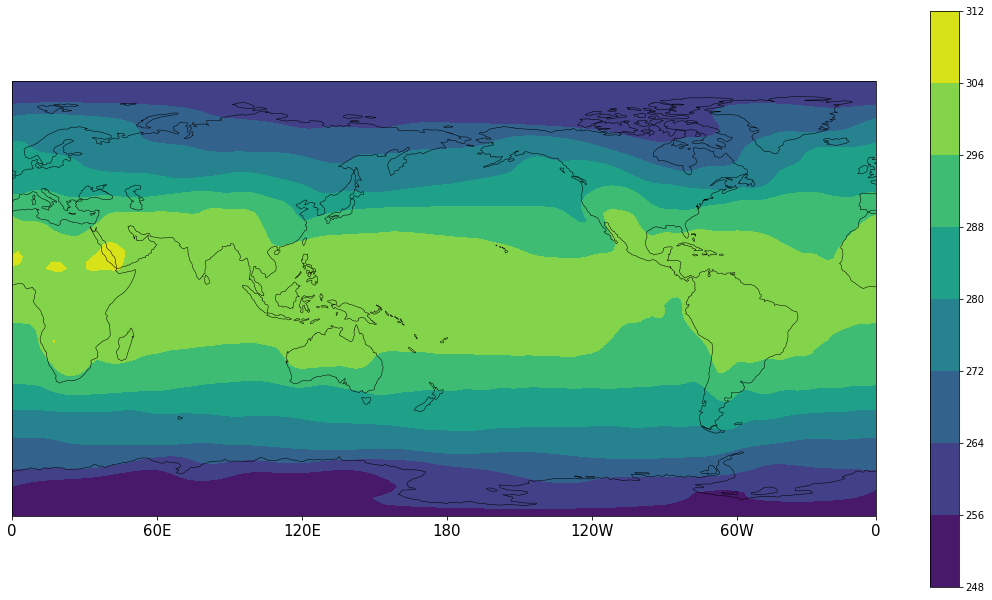

In [7]:
#画图
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_axes([0,0,1,1],projection = ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cf.COASTLINE,lw=0.5,zorder=2)
ax1.set_xticks([0,60,120,180,240,300,357.5],crs=ccrs.PlateCarree())
ax1.set_xticklabels(['0','60E','120E','180','120W','60W','0'],fontsize=15)
con1 = ax1.contourf(X,Y,air_mean,transform=ccrs.PlateCarree())
fig.colorbar(con1)

## 测试4：研究区域为经度0度附近区域
两种解决方法参考：

1）cartopy里面的add_cyclic_point函数可以直接把357.5 → 0看成连续的，来自@一阶魔方国家队成员 大佬

2）可对0度附近区域进行插值(仅提供参考思路，本人未进行测试)

### 测试4.1 cartopy.util.add_cyclic_point+中心经线为0度的情况
记得from cartopy.util import add_cyclic_point

注意：xticks从0→360变成-180→180

In [23]:
#新的air_mean1和lon1
air_mean1,lon1 = add_cyclic_point(air_mean,coord=lon)

#新的画图网格1
X1,Y1 = np.meshgrid(lon1,lat)

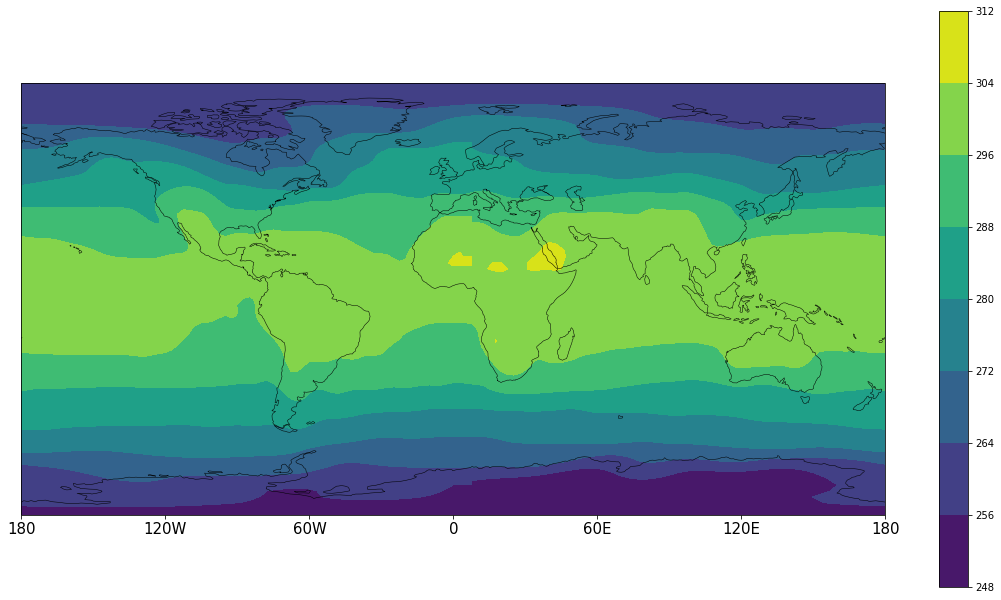

In [24]:
#画图
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_axes([0,0,1,1],projection = ccrs.PlateCarree())
ax1.set_xticks([-180,-120,-60,0,60,120,180],crs=ccrs.PlateCarree())
ax1.set_xticklabels(['180','120W','60W','0','60E','120E','180'],fontsize=15)
ax1.add_feature(cf.COASTLINE,lw=0.5,zorder=2)  #绘制海岸线
con1 = ax1.contourf(X1,Y1,air_mean1,transform=ccrs.PlateCarree())
fig.colorbar(con1)

### 测试4.2  add_cyclic_point方法+中心经线为180度的情况

注意：经本人测试，add_cyclic_point生成的新的lon里面有360，但xticks仍然没法取到360，可取359.9并给它添加label为0度

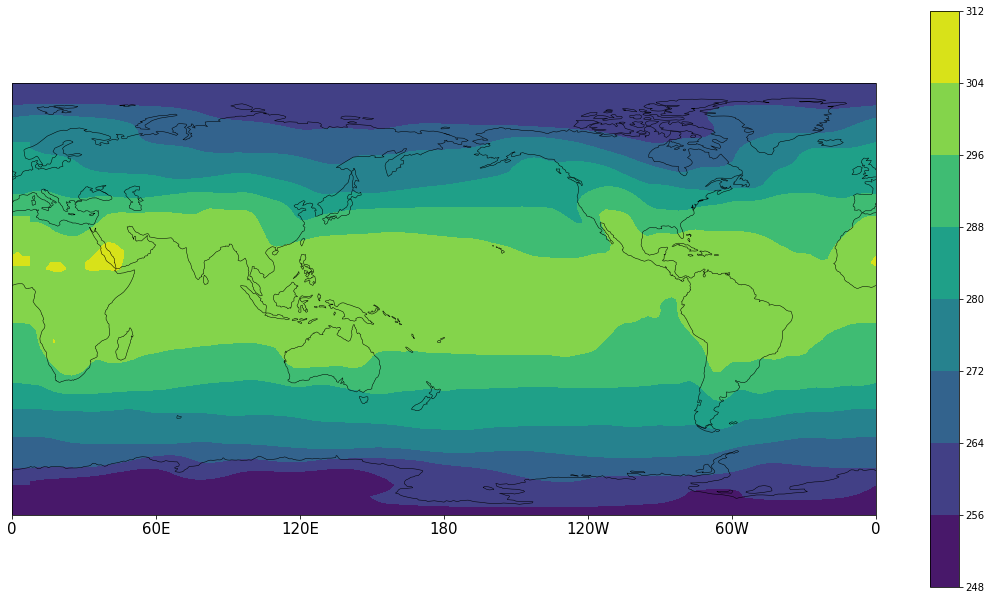

In [25]:
#画图
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_axes([0,0,1,1],projection = ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cf.COASTLINE,lw=0.5,zorder=2)
ax1.set_xticks([0,60,120,180,240,300,359.9],crs=ccrs.PlateCarree())
ax1.set_xticklabels(['0','60E','120E','180','120W','60W','0'],fontsize=15)
con1 = ax1.contourf(X1,Y1,air_mean1,transform=ccrs.PlateCarree())
fig.colorbar(con1)

## 提示：项目中最终展示的图并非完全成品，建议读者自行尝试添加纬度坐标(yticks&yticklabels)、标题(title)、colorbar标题/单位等并进行调整和美化，调整和美化方法可参考【气象科研绘图1-5】